## Install RSOME and the ECOS solver

In [9]:
!pip install rsome --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 KB 321.3 kB/s eta 0:00:00a 0:00:01


In [7]:
!pip install ecos

## Application of Vehicle Preallocation

### Import RSOME and other analytical tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

In [2]:
pd.options.display.max_rows = 7

### Dataset and model parameters
#### Data on demand and precipitation

In [3]:
data = pd.read_csv('https://xiongpengnus.github.io/rsome/taxi_rain.csv')

In [4]:
demand = data.loc[:, 'Region1':'Region10']
demand

,Region1,Region2,Region3,Region4,Region5,Region6,Region7,Region8,Region9,Region10
0,0.000000,0.000000,0.000000,0.000000,0.000000,39.613757,1.316626,0.770319,0.000000,2.408292
1,5.169759,0.000000,2.990986,0.000000,0.000000,54.822255,2.702401,4.682649,0.000000,8.641518
2,0.000000,0.000000,0.000000,0.000000,0.640985,57.202410,6.523627,3.707144,0.000000,3.232930
...,...,...,...,...,...,...,...,...,...,...
74,2.649001,6.784071,0.000000,5.542861,0.000000,93.231729,1.713845,0.000000,0.225335,1.851765
75,21.418156,19.711290,26.874735,43.991484,3.768123,174.943747,12.610632,38.532604,30.980223,18.556275
76,0.000000,4.535048,4.168807,0.000000,2.104692,105.036031,0.000000,4.535980,7.001034,0.000000


In [5]:
precip = data.loc[:, 'S08_Rain_Amount': 'S88_Rain_Amount']
precip

,S08_Rain_Amount,S107_Rain_Amount,S108_Rain_Amount,S78_Rain_Amount,S79_Rain_Amount,S88_Rain_Amount
0,0.1,0.0,0.0,0.0,0.1,0.0
1,0.0,0.8,0.1,0.0,0.0,0.0
2,0.6,0.6,0.7,0.4,0.4,0.5
...,...,...,...,...,...,...
74,0.0,0.0,0.0,0.0,0.0,0.0
75,1.3,0.3,15.6,4.6,4.3,4.4
76,0.0,0.0,0.0,0.0,0.0,0.0


#### Supply and demand node coefficients

In [6]:
I = 1                                                 # number of supply nodes
J = demand.shape[1]                                   # number of demand nodes
r = np.array([4.8, 4.692, 3.732, 4.788, 4.656, 
              4.896, 4.836, 4.968, 4.896, 4.584])     # revenue coefficients
c = 3 * np.ones((I, J))                               # cost coefficients 
q = 400 * np.ones(I)                                  # maximum supply of vehicles

### Implementation using `RSOME`
#### The robust model

In [14]:
d_ub = demand.max().values                  # upper bound of demand
d_lb = demand.min().values                  # lower bound of demand

In [15]:
from rsome import ro                        # import the ro module
from rsome import eco_solver as eco         # import the Gurobi interface

model = ro.Model()                          # create an RO model

d = model.rvar(J)                           # create an array of random variables
zset = (d <= d_ub, d >= d_lb)               # define a box uncertainty set

x = model.dvar((I, J))                      # define here-and-now decisions as array x
y = model.ldr(J)                            # define linear decision rules as array y
y.adapt(d)                                  # y affinely adapts to d

model.minmax(((c-r)*x).sum() + r@y, zset)   # minimize the worst-case objective 
model.st(y >= x.sum(axis=0) - d, y >= 0)    # robust constraints
model.st(x.sum(axis=1) <= q, x >= 0)        # deterministic constraints

model.solve(eco)                            # solve the model with Gurobi

Being solved by ECOS...
Solution status: Optimal solution found
Running time: 0.0038s


In [16]:
model.get()

-75.10768250566842

In [31]:
x1 = x.get()
x1.round(5)

array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     , 39.61376,
         0.     ,  0.     ,  0.     ,  0.     ]])

In [29]:
model.do_math()

Second order cone program object:
Number of variables:          373
Continuous/binaries/integers: 373/0/0
---------------------------------------------
Number of linear constraints: 232
Inequalities/equalities:      211/21
Number of coefficients:       823
---------------------------------------------
Number of SOC constraints:    0

#### The sample robust model using the `ro` framework

In [33]:
dhat = demand.values                                    # sample demand as an array
S = dhat.shape[0]                                       # sample size of the dataset
epsilon = 0.25                                          # parameter of robustness
w = 1/S                                                 # weights of scenarios

In [34]:
from rsome import ro                                    # import the ro module
from rsome import norm                                  # import the norm function
from rsome import eco_solver as eco                     # import the Gurobi interface

model = ro.Model()                                      # create an RO model

d = model.rvar(J)                                       # random variable d
a = model.dvar(S)                                       # variable as the recourse cost
x = model.dvar((I, J))                                  # here-and-now decision x
y = model.ldr((S, J))                                   # linear decision rule y
y.adapt(d)                                              # y affinely adapts to d

model.min(((c-r)*x).sum() + w*a.sum())                  # minimize the objective
for s in range(S):
    zset = (d <= d_ub, d >= d_lb, 
            norm(d - dhat[s]) <= epsilon)               # sample-wise uncertainty set
    model.st((a[s] >= r@y[s]).forall(zset))             # constraints for the sth sample
    model.st((y[s] >= x.sum(axis=0) - d).forall(zset))  # constraints for the sth sample
    model.st((y[s] >= 0).forall(zset))                  # constraints for the sth sample
model.st(x.sum(axis=1) <= q, x >= 0)                    # constraints

model.solve(eco)                                        # solve the model by Gruobi

Being solved by ECOS...
Solution status: Optimal solution found
Running time: 1.0107s


In [35]:
model.get()

-130.15908159148634

In [36]:
x2 = x.get()
x2.round(5)

array([[ 0.6697 ,  3.00859,  0.     ,  4.34011,  0.     , 70.92135,
         3.99641,  5.18537,  5.82321,  3.82512]])

In [37]:
model.do_math()

Second order cone program object:
Number of variables:          44132
Continuous/binaries/integers: 44132/0/0
---------------------------------------------
Number of linear constraints: 17789
Inequalities/equalities:      16172/1617
Number of coefficients:       92526
---------------------------------------------
Number of SOC constraints:    1617

#### The sample robust model using the `dro` framework

In [38]:
dhat = demand.values                                # sample demand as an array
S = dhat.shape[0]                                   # sample size of the dataset
epsilon = 0.25                                      # parameter of robustness
w = 1/S                                             # weights of scenarios

In [39]:
from rsome import dro                               # import the dro module
from rsome import norm                              # import the norm function
from rsome import E                                 # import the expectation notion
from rsome import eco_solver as eco                 # import the Gurobi interface

model = dro.Model(S)                                # a DRO model with S scenarios

d = model.rvar(J)                                   # random variable d
fset = model.ambiguity()                            # create an ambiguity set
for s in range(S):                                  # for each scenario
    fset[s].suppset(d <= d_ub, d >= d_lb, 
                    norm(d - dhat[s]) <= epsilon)   # define the support set
pr = model.p                                        # an array of scenario weights
fset.probset(pr == w)                               # specify scenario weights

x = model.dvar((I, J))                              # here-and-now decision x
y = model.dvar(J)                                   # wait-and-see decision y
y.adapt(d)                                          # y affinely adapts to d
for s in range(S):
    y.adapt(s)                                      # y adapts to each scenario s

model.minsup(((c-r)*x).sum() + E(r@y), fset)        # the worst-case expectation
model.st(y >= x.sum(axis=0) - d, y >= 0)            # robust constraints
model.st(x.sum(axis=1) <= q, x >= 0)                # deterministic constraints

model.solve(eco)                                    # solve the model by Gruobi

Being solved by ECOS...
Solution status: Optimal solution found
Running time: 1.2202s


In [40]:
model.get()

-130.15908156563754

In [41]:
x.get().round(5)

array([[ 0.6697 ,  3.00859,  0.     ,  4.34011,  0.     , 70.92135,
         3.99641,  5.18537,  5.82321,  3.82512]])

In [21]:
model.do_math()

Second order cone program object:
Number of variables:          44288
Continuous/binaries/integers: 44288/0/0
---------------------------------------------
Number of linear constraints: 18713
Inequalities/equalities:      17019/1694
Number of coefficients:       95203
---------------------------------------------
Number of SOC constraints:    1617

#### Distributionally robust optimization model considering side information

In [42]:
regr = DecisionTreeRegressor(max_leaf_nodes=4,          # max leaf nodes
                             min_samples_leaf=3)        # min sample size of each leaf
regr.fit(precip, demand)
mu, index, counts = np.unique(regr.predict(precip), 
                              axis=0,
                              return_inverse=True,
                              return_counts=True)       # conditional mean
w = counts/precip.shape[0]                              # scenario weights         
phi = np.array([demand.values[index==i].var(axis=0)
                for i in range(len(counts))])           # conditional variance
d_ub = np.array([demand.values[index==i].max(axis=0)
                for i in range(len(counts))])           # upper bound of each scenario
d_lb = np.array([demand.values[index==i].min(axis=0)
                for i in range(len(counts))])           # lower bound of each scenario

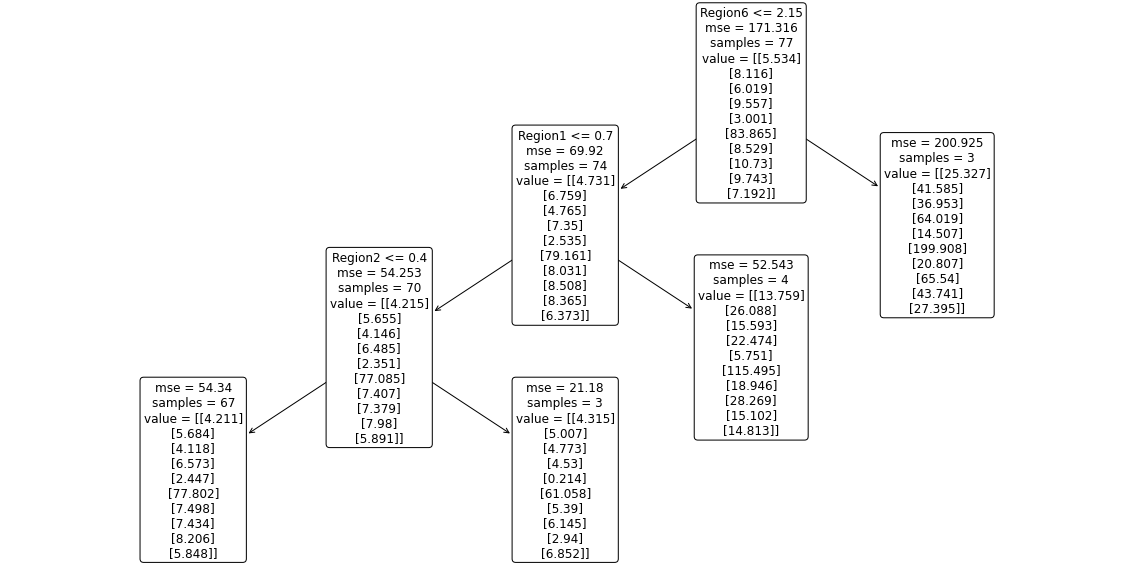

In [43]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 9))
plot_tree(regr, rounded=True, feature_names=demand.columns, fontsize=12)
plt.show()

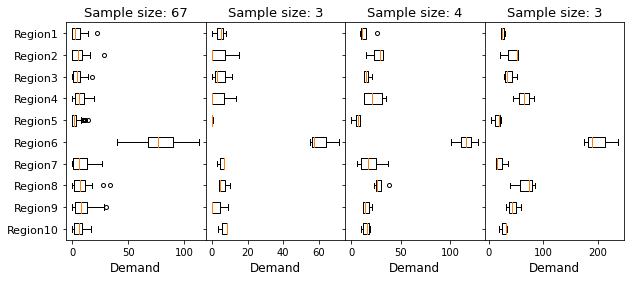

In [44]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
axes = gs.subplots(sharey='row')
for i in range(4):
    each_demand = demand.values[index==i]
    axes[i].boxplot(each_demand, 
                    vert=False, flierprops={'markersize': 4})
    axes[i].set_yticks(list(range(1, 11)), 
                       ['Region{0}'.format(i) for i in range(1, 11)], 
                       fontsize=11)
    axes[i].set_xlabel('Demand', fontsize=12)
    axes[i].set_title('Sample size: {0}'.format(each_demand.shape[0]), 
                      fontsize=13)
axes[3].set_ylim(10.5, 0.5)
plt.show()

In [45]:
from rsome import dro                         # import the dro module
from rsome import square                      # import the element-wise square function
from rsome import E                           # import the notion of expectation
from rsome import eco_solver as eco           # import the Gurobi interface

S = len(w)
model = dro.Model(S)                          # create a DRO model with S scenarios

d = model.rvar(J)                             # random demand as the variable d
u = model.rvar(J)                             # auxiliary random variable u
fset = model.ambiguity()                      # create an ambiguity set
for s in range(S):                            # for each scenario:
    fset[s].exptset(E(d) == mu[s],            # specify the expectation set of d and u
                    E(u) <= phi[s])
    fset[s].suppset(d >= d_lb[s],             # specify the support of d and u
                    d <= d_ub[s],
                    square(d - mu[s]) <= u)
pr = model.p                                  # an array of scenario probabilities
fset.probset(pr == w)                         # w as scenario weights

x = model.dvar((I, J))                        # here-and-now decision x
y = model.dvar(J)                             # wait-and-see decision y
y.adapt(d)                                    # y affinely adapts to d
y.adapt(u)                                    # y affinely adapts to u
for s in range(S):                            # for each scenario:
    y.adapt(s)                                # affine adaptation of y is different

model.minsup(((c-r)*x).sum() + E(r@y), fset)  # minimize the worst-case objective
model.st(y >= x.sum(axis=0) - d, y >= 0)      # robust constraints
model.st(x >= 0, x.sum(axis=0) <= q)          # deterministic constraints

model.solve(eco)                              # solve the model by Gurobi
status = model.solution.status                # return the solution status
time = model.solution.time                    # return the solution time
objval = model.get()                          # get the optimal objective value
x_sol = x.get()                               # get the optimal solution

Being solved by ECOS...
Solution status: Optimal solution found
Running time: 0.1126s


In [46]:
model.get()

-111.33291087626135

In [47]:
x3 = x.get()
x3.round(5)

array([[ 0.     ,  0.     ,  0.     ,  5.51733,  0.     , 74.41608,
         0.     ,  3.70714,  7.03957,  4.79476]])

In [28]:
model.do_math()

Second order cone program object:
Number of variables:          4889
Continuous/binaries/integers: 4889/0/0
---------------------------------------------
Number of linear constraints: 1930
Inequalities/equalities:      502/1428
Number of coefficients:       10759
---------------------------------------------
Number of SOC constraints:    840

#### Visualization of allocation decisions

Text(0, 0.5, 'Allocated quantities')

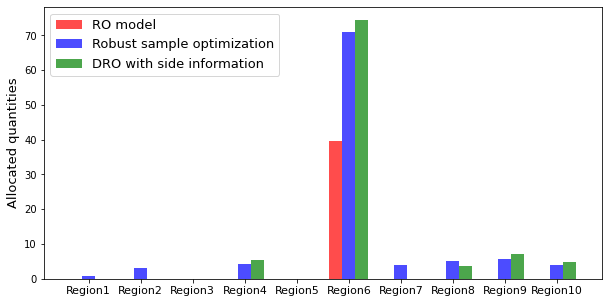

In [57]:
width=0.25
labels = demand.columns

plt.figure(figsize=(10, 5))
plt.bar(np.arange(0, len(labels)) - 1*width, x1.flatten(), 
        width=width, color='r', alpha=0.7, 
        label='RO model')
plt.bar(np.arange(0, len(labels)), x2.flatten(), 
        width=width, color='b', alpha=0.7, 
        label='Robust sample optimization')
plt.bar(np.arange(0, len(labels)) + 1*width, x3.flatten(), 
        width=width, color='g', alpha=0.7,
        label='DRO with side information')
plt.legend(fontsize=13)
plt.xticks(np.arange(0, len(labels)), labels, fontsize=11)
plt.ylabel('Allocated quantities', fontsize=13)